# 과제: Groove Midi dataset과 MusicVAE를 활용하여 드럼 샘플 추출

- 관련 논문: A Hierarchical Latent Vector Model for Learning Long-Term Structure in Music
- 논문 링크: https://arxiv.org/pdf/1803.05428.pdf

- 기존에 사용되던 VAE 모델은 장기적인 구조의 시퀀스를 모델링을 하는 데 있어 어려움이 있다.
- 하여 논문에서 제안하는 모델은 계층적 디코더이며 모델이 잠재된 코드를 사용하도록 장려되는 구조적 특성으로 인해 기존 VAE 모델의 고질적인 문제인 **“posterior collapse(후방 붕괴)”**를 예방할 수 있는 모델이다.
- 해당 모델은 보다 긴 시퀀스의 데이터를 효과적으로 처리할 수 있으며 이를 Music VAE라 칭한다.

## magenta 설치

In [1]:
!pip install magenta==2.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### magenta(마젠타)
- 음악과 미술을 만드는 방법을 학습할 수 있는 알고리즘을 개발해 기계가 스스로 예술적인 콘텐츠를 만들 수 있도록 하는 프로젝트

In [3]:
# 필요 모듈
import os
import numpy as np
import pathlib
import IPython
import collections
import pandas as pd
import note_seq
import zipfile

# 그래프 관련 모듈
import matplotlib.pyplot as plt
import seaborn as sns

# magenta 관련 모듈
from magenta.models.music_vae import MusicVAE
from magenta.models.music_vae import lstm_models
from magenta.models.music_vae import data
from magenta.scripts.convert_dir_to_note_sequences import convert_directory
from magenta.common import merge_hparams
from magenta.contrib import training as contrib_training
from magenta.models.music_vae import configs
from magenta.models.music_vae.trained_model import TrainedModel

# 텐서플로우 관련 모듈
import tensorflow as tf
import tensorflow.compat.v1 as tf
import tf_slim 

### 파일 불러오기

- magenta 웹사이트에서 midi 형식의 파일만 압축된 zip파일 불러오기

In [4]:
url = "https://storage.googleapis.com/magentadata/datasets/groove/groove-v1.0.0-midionly.zip"
dir = tf.keras.utils.get_file(origin=url, 
                                   fname='/content/drive/MyDrive/포자랩스/midi_data.zip', 
                                   extract=True)
data_dir = pathlib.Path(dir)

- zip파일 압축 해제

In [5]:
zipfile.ZipFile(data_dir).extractall()

- 데이터 경로 지정

In [6]:
#경로지정
data_root= '/content/drive/MyDrive/포자랩스/groove' # 데이터 경로
csv_file = '/content/drive/MyDrive/포자랩스/groove/info.csv' # midi파일의 session, id, bpm 등의 정보를 담고 있는 파일.
tfrec_root = '/content/drive/MyDrive/포자랩스/music.tfrecord'# tfrecord 파일이 생성될 경로를 지정

- pandas를 통해 info.csv 파일 확인

In [7]:
import pandas as pd
midi = pd.read_csv(csv_file)
midi = pd.DataFrame(midi)
print('전체 데이터 갯수: ', len(midi)) # 전체 데이터 갯수 확인
midi.head(10) # 상단의 10개의 데이터 확인

전체 데이터 갯수:  1150


,drummer,session,id,style,bpm,beat_type,time_signature,midi_filename,audio_filename,duration,split
0,drummer1,drummer1/eval_session,drummer1/eval_session/1,funk/groove1,138,beat,4-4,drummer1/eval_session/1_funk-groove1_138_beat_...,drummer1/eval_session/1_funk-groove1_138_beat_...,27.872308,test
1,drummer1,drummer1/eval_session,drummer1/eval_session/10,soul/groove10,102,beat,4-4,drummer1/eval_session/10_soul-groove10_102_bea...,drummer1/eval_session/10_soul-groove10_102_bea...,37.691158,test
2,drummer1,drummer1/eval_session,drummer1/eval_session/2,funk/groove2,105,beat,4-4,drummer1/eval_session/2_funk-groove2_105_beat_...,drummer1/eval_session/2_funk-groove2_105_beat_...,36.351218,test
3,drummer1,drummer1/eval_session,drummer1/eval_session/3,soul/groove3,86,beat,4-4,drummer1/eval_session/3_soul-groove3_86_beat_4...,drummer1/eval_session/3_soul-groove3_86_beat_4...,44.716543,test
4,drummer1,drummer1/eval_session,drummer1/eval_session/4,soul/groove4,80,beat,4-4,drummer1/eval_session/4_soul-groove4_80_beat_4...,drummer1/eval_session/4_soul-groove4_80_beat_4...,47.987500,test
5,drummer1,drummer1/eval_session,drummer1/eval_session/5,funk/groove5,84,beat,4-4,drummer1/eval_session/5_funk-groove5_84_beat_4...,drummer1/eval_session/5_funk-groove5_84_beat_4...,45.687518,test
6,drummer1,drummer1/eval_session,drummer1/eval_session/6,hiphop/groove6,87,beat,4-4,drummer1/eval_session/6_hiphop-groove6_87_beat...,drummer1/eval_session/6_hiphop-groove6_87_beat...,44.119242,test
7,drummer1,drummer1/eval_session,drummer1/eval_session/7,pop/groove7,138,beat,4-4,drummer1/eval_session/7_pop-groove7_138_beat_4...,drummer1/eval_session/7_pop-groove7_138_beat_4...,27.706547,test
8,drummer1,drummer1/eval_session,drummer1/eval_session/8,rock/groove8,65,beat,4-4,drummer1/eval_session/8_rock-groove8_65_beat_4...,drummer1/eval_session/8_rock-groove8_65_beat_4...,59.067313,test
9,drummer1,drummer1/eval_session,drummer1/eval_session/9,soul/groove9,105,beat,4-4,drummer1/eval_session/9_soul-groove9_105_beat_...,drummer1/eval_session/9_soul-groove9_105_beat_...,36.540504,test


#### midi data의 장르(style) 구성 확인 및 시각화

- 위 데이터프레임에서 'style' 칼럼만 따로 style이란 변수로 지정

In [8]:
style = midi['style']
style

0        funk/groove1
1       soul/groove10
2        funk/groove2
3        soul/groove3
4        soul/groove4
            ...      
1145             rock
1146             rock
1147             rock
1148             rock
1149             rock
Name: style, Length: 1150, dtype: object

- style 칼럼을 살펴보면 '/'를 기준으로 장르가 나누어져 있기 때문에 split 함수를 활용하여 
분리

In [9]:
style_split = style.str.split('/')
print(style_split.head(20))

0              [funk, groove1]
1             [soul, groove10]
2              [funk, groove2]
3              [soul, groove3]
4              [soul, groove4]
5              [funk, groove5]
6            [hiphop, groove6]
7               [pop, groove7]
8              [rock, groove8]
9              [soul, groove9]
10                      [funk]
11                [jazz, funk]
12    [neworleans, secondline]
13              [dance, disco]
14                      [funk]
15                      [funk]
16                      [funk]
17                      [funk]
18                      [funk]
19                      [funk]
Name: style, dtype: object


- '/'를 기준으로 split을 하면 style이 하나만 존재하는 데이터도 있기 때문에 구분된 style에서 첫번째 데이터만 따로 분류

In [10]:
style = style_split.str.get(0)
style.head(10)

0      funk
1      soul
2      funk
3      soul
4      soul
5      funk
6    hiphop
7       pop
8      rock
9      soul
Name: style, dtype: object

- seaborn의 countplot을 사용해 각 장르의 전체 분포를 확인

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


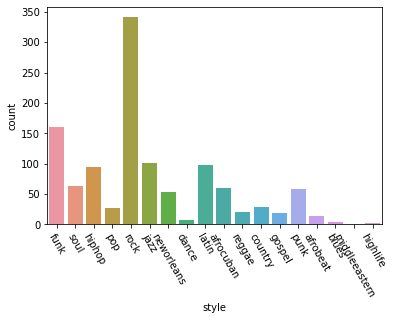

In [11]:
ax = plt.subplots()
ax = sns.countplot(style)
ax = plt.xticks(rotation = -60)

### TFRecords 형식으로 변환 전 'music21'이란 모듈을 통해 midi 파일의 pitch, chord 등을 확인

In [12]:
!pip install music21

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
from music21 import converter, corpus, instrument, midi, note, chord, pitch

def open_midi(midi_path):
    mf = midi.MidiFile()
    mf.open(midi_path)
    mf.read()
    mf.close()
   
    return midi.translate.midiFileToStream(mf)
    
base_midi = open_midi('/content/drive/MyDrive/포자랩스/groove/drummer1/session1/102_funk_95_beat_4-4.mid')
base_midi

<music21.stream.Score 0x7f97f5653910>

meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 11 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/stop>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/stop>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, None, None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/st

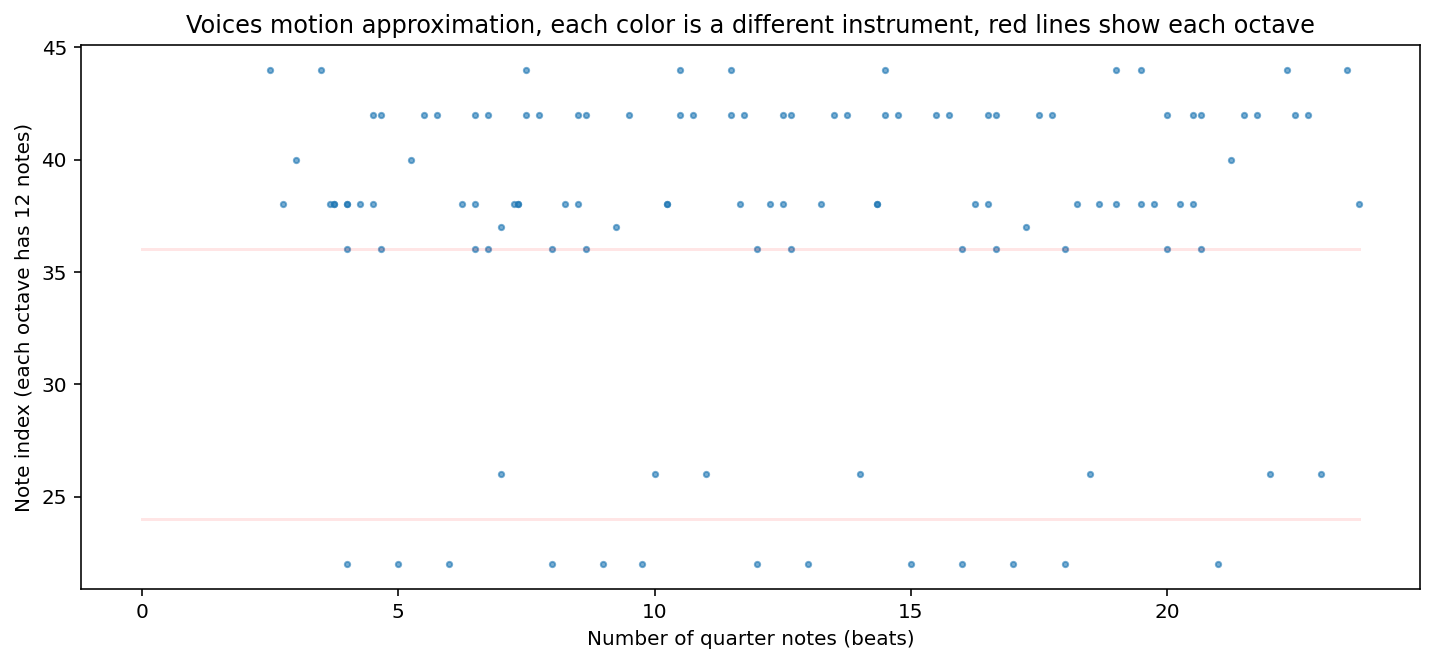

In [14]:
import matplotlib.lines as mlines

def extract_notes(midi_part):
    parent_element = []
    ret = []
    for nt in midi_part.flat.notes:        
        if isinstance(nt, note.Note):
            ret.append(max(0.0, nt.pitch.ps))
            parent_element.append(nt)
        elif isinstance(nt, chord.Chord):
            for pitch in nt.pitches:
                ret.append(max(0.0, pitch.ps))
                parent_element.append(nt)
    
    return ret, parent_element

def print_parts_countour(midi):
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(1, 1, 1)
    minPitch = pitch.Pitch('C10').ps
    maxPitch = 0
    xMax = 0
    
    # Drawing notes.
    for i in range(len(midi.parts)):
        top = midi.parts[i].flat.notes                  
        y, parent_element = extract_notes(top)
        if (len(y) < 1): continue
            
        x = [n.offset for n in parent_element]
        ax.scatter(x, y, alpha=0.6, s=7)
        
        aux = min(y)
        if (aux < minPitch): minPitch = aux
            
        aux = max(y)
        if (aux > maxPitch): maxPitch = aux
            
        aux = max(x)
        if (aux > xMax): xMax = aux
    
    for i in range(1, 10):
        linePitch = pitch.Pitch('C{0}'.format(i)).ps
        if (linePitch > minPitch and linePitch < maxPitch):
            ax.add_line(mlines.Line2D([0, xMax], [linePitch, linePitch], color='red', alpha=0.1))            

    plt.ylabel("Note index (each octave has 12 notes)")
    plt.xlabel("Number of quarter notes (beats)")
    plt.title('Voices motion approximation, each color is a different instrument, red lines show each octave')
    plt.show()

# Focusing only on 6 first measures to make it easier to understand.
print_parts_countour(base_midi.measures(0, 6))

- ⬆️ 각 악기의 음정의 높이를 표시한 그래프.

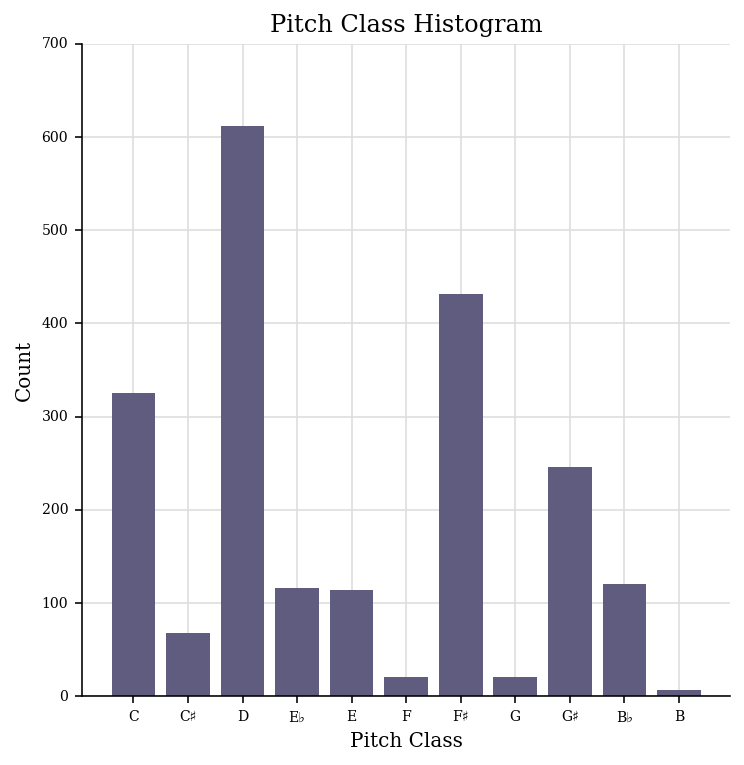

In [15]:
base_midi.plot('histogram', 'pitchClass', 'count')

- ⬆️ 곡 전체에서 많이 쓰이는 음정(pitch)을 히스토그램으로 표현

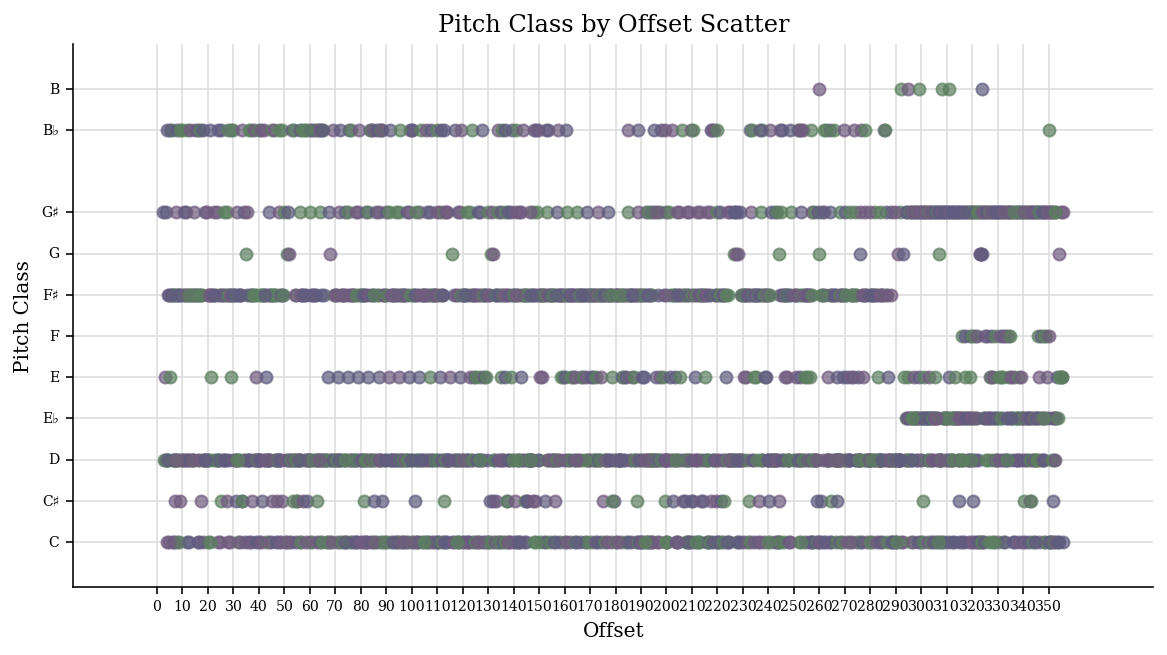

In [16]:
base_midi.plot('scatter', 'offset', 'pitchClass')

### TFRecords 형식으로 전처리

#### TFRecords 형식으로 변환이 필요한 이유
  - TFRecord 파일은 tensorflow의 학습 데이터등을 저장하기 위한 바이너리 데이터 포맷
  - midi 파일을 기존의 포맷으로 읽어서 매번 디코딩을 하게되면, 학습 단계의 데이터를 읽는 부분에서 많은 성능 저하가 발생
  - TFRecord를 사용하는 것으로, 대규모 데이터를 효율적으로 학습할 수 있다.

---

- magenta의 convert_directory 함수를 사용해 포맷 변환 진행

In [17]:
help(convert_directory)

Help on function convert_directory in module magenta.scripts.convert_dir_to_note_sequences:

convert_directory(root_dir, output_file, recursive=False)
    Converts files to NoteSequences and writes to `output_file`.
    
    Input files found in `root_dir` are converted to NoteSequence protos with the
    basename of `root_dir` as the collection_name, and the relative path to the
    file from `root_dir` as the filename. If `recursive` is true, recursively
    converts any subdirectories of the specified directory.
    
    Args:
      root_dir: A string specifying a root directory.
      output_file: Path to TFRecord file to write results to.
      recursive: A boolean specifying whether or not recursively convert files
          contained in subdirectories of the specified directory.



In [18]:
convert_directory(data_root,tfrec_root,recursive=True)

### 논문에서 제안하는 모델구조

  - Encoder: BidirectionalLSTM(양방향 LSTM)
      - 2층의 layer로 구성된 양방향 LSTM
      - 과거와 미래, 양방향으로 시퀀스 정보를 가질 수 있다.
      - 입력 시퀀스(x = {x1, x2, ., xT})를 처리하여 두 번째 양방향 LSTM 계층에서 최종 상태 벡터를 얻는다.

  - Decoder: Hierarchical Decoder(GrooveLSTM)
      - Simple RNN을 사용하면 긴 시퀀스에 대한 샘플링 및 재구성 상태가 좋지 않다.
      - 2층의 layer로 구성된 단방향 LSTM

#### Drum 관련 모델만 따로 Config

In [19]:
class Config(collections.namedtuple(
    'Config',
    ['model', 'hparams', 'note_sequence_augmenter', 'data_converter',
     'train_examples_path', 'eval_examples_path', 'tfds_name'])):

    def values(self):
        return self._asdict()

Config.__new__.__defaults__ = (None,) * len(Config._fields)


def update_config(config, update_dict):
    config_dict = config.values()
    config_dict.update(update_dict)
    return Config(**config_dict)


CONFIG_MAP = {}


HParams = contrib_training.HParams


# LSTM 모델의 구조
CONFIG_MAP['nade-drums_2bar_full'] = Config(
    model=MusicVAE(lstm_models.BidirectionalLstmEncoder(),
                   lstm_models.GrooveLstmDecoder()),
    hparams=merge_hparams(
        lstm_models.get_default_hparams(),
        HParams(
            batch_size=512,
            max_seq_len=32,
            z_size=256,
            enc_rnn_size=[2048],
            dec_rnn_size=[1024, 1024],
            nade_num_hidden=128,
            free_bits=48,
            max_beta=0.2,
            sampling_schedule='inverse_sigmoid',
            sampling_rate=1000,
        )),
    note_sequence_augmenter=None,
    data_converter=data.GrooveConverter(
        split_bars=4, steps_per_quarter=4, quarters_per_bar=4,
        max_tensors_per_notesequence=20,
        pitch_classes=data.ROLAND_DRUM_PITCH_CLASSES,

        inference_pitch_classes=data.REDUCED_DRUM_PITCH_CLASSES),
    
    train_examples_path='/content/drive/MyDrive/포자랩스/music.tfrecord', #데이터 경로 설정
)

### 모델 훈련

In [20]:
def _trial_summary(hparams, examples_path, output_dir):

  examples_path_summary = tf.summary.text(
      'examples_path', tf.constant(examples_path, name='examples_path'),
      collections=[])

  hparams_dict = hparams.values()


  header = '| Key | Value |\n| :--- | :--- |\n'
  keys = sorted(hparams_dict.keys())
  lines = ['| %s | %s |' % (key, str(hparams_dict[key])) for key in keys]
  hparams_table = header + '\n'.join(lines) + '\n'

  hparam_summary = tf.summary.text(
    'hparams', tf.constant(hparams_table, name='hparams'), collections=[])

  with tf.Session() as sess:
      writer = tf.summary.FileWriter(output_dir, graph=sess.graph)
      writer.add_summary(examples_path_summary.eval())
      writer.add_summary(hparam_summary.eval())
      writer.close()


def _get_input_tensors(dataset, config):
    batch_size = config.hparams.batch_size
    iterator = tf.data.make_one_shot_iterator(dataset)
    (input_sequence, output_sequence, control_sequence,
    sequence_length) = iterator.get_next()
    input_sequence.set_shape(
    [batch_size, None, config.data_converter.input_depth])
    output_sequence.set_shape(
    [batch_size, None, config.data_converter.output_depth])
    
    if not config.data_converter.control_depth:
      control_sequence = None
    
    else:
      control_sequence.set_shape(
          [batch_size, None, config.data_converter.control_depth])
      sequence_length.set_shape([batch_size] + sequence_length.shape[1:].as_list())
        
    return {
        'input_sequence': input_sequence,
        'output_sequence': output_sequence,
        'control_sequence': control_sequence,
        'sequence_length': sequence_length
    }

def train(train_dir,
          config,
          dataset_fn,
          checkpoints_to_keep=5,
          keep_checkpoint_every_n_hours=1,
          num_steps=None,
          master='',
          num_sync_workers=0,
          num_ps_tasks=0,
          task=0):

#==== train loop ====
    tf.gfile.MakeDirs(train_dir)
    is_chief = (task == 0)

    with tf.Graph().as_default():
        with tf.device(tf.train.replica_device_setter(
            num_ps_tasks, merge_devices=True)):
            
            model = config.model
            model.build(config.hparams,
                        config.data_converter.output_depth,
                        is_training=True)
            #== 옵티마이저 ===
            optimizer = model.train(**_get_input_tensors(dataset_fn(), config))

            hooks = []
            if num_sync_workers:
                optimizer = tf.train.SyncReplicasOptimizer(
                    optimizer,num_sync_workers)
                hooks.append(optimizer.make_session_run_hook(is_chief))

            grads, var_list = list(zip(*optimizer.compute_gradients(model.loss)))
            global_norm = tf.global_norm(grads)
            tf.summary.scalar('global_norm', global_norm)
            
            if config.hparams.clip_mode == 'value':
                g = config.hparams.grad_clip
                clipped_grads = [tf.clip_by_value(grad, -g, g) for grad in grads]
            elif config.hparams.clip_mode == 'global_norm':
                clipped_grads = tf.cond(
                    global_norm < config.hparams.grad_norm_clip_to_zero,
                    lambda: tf.clip_by_global_norm(  # pylint:disable=g-long-lambda
                        grads, config.hparams.grad_clip, use_norm=global_norm)[0],
                    lambda: [tf.zeros(tf.shape(g)) for g in grads])
            else:
                raise ValueError(
                    'Unknown clip_mode: {}'.format(config.hparams.clip_mode))
            train_op = optimizer.apply_gradients(
                list(zip(clipped_grads, var_list)),
                global_step=model.global_step,
                name='train_step')
            logging_dict = {'global_step': model.global_step,
                            'loss': model.loss}
            
            hooks.append(tf.train.LoggingTensorHook(logging_dict, every_n_iter=100))
            if num_steps:
                hooks.append(tf.train.StopAtStepHook(last_step=num_steps))
                
            scaffold = tf.train.Scaffold(
                saver=tf.train.Saver(
                    max_to_keep=checkpoints_to_keep,
                    keep_checkpoint_every_n_hours=keep_checkpoint_every_n_hours))
            
            tf_slim.training.train(
                train_op=train_op,
                logdir=train_dir,
                scaffold=scaffold,
                hooks=hooks,
                save_checkpoint_secs=60,
                master=master,
                is_chief=is_chief)


def run(config_map,
        tf_file_reader=tf.data.TFRecordDataset,
        file_reader=tf.python_io.tf_record_iterator,
        is_training=True):
    config = config_map['nade-drums_2bar_full']
    train_dir = '/content/drive/MyDrive/포자랩스/check_points'
    num_steps = 20000
    
    def dataset_fn():
        return data.get_dataset(
            config,
            tf_file_reader=tf_file_reader,
            is_training=True,
            cache_dataset=True)
    
    if is_training == True:
        train(
            train_dir,
            config=config,
            dataset_fn=dataset_fn,
            num_steps=num_steps)      
    
    else:
        print("EVAL")

In [47]:
run(CONFIG_MAP) #epoch 20000

/usr/local/lib/python3.8/dist-packages/magenta/contrib/rnn.py:750: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  self._kernel = self.add_variable(
/usr/local/lib/python3.8/dist-packages/magenta/contrib/rnn.py:752: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  self._bias = self.add_variable(
/usr/local/lib/python3.8/dist-packages/magenta/models/music_vae/base_model.py:195: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  mu = tf.layers.dense(
/usr/local/lib/python3.8/dist-packages/magenta/models/music_vae/base_model.py:200: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  sigma = tf.layers.dense(
/usr/local/lib/python3.8/dist-package

### 훈련된 모델로 midi파일 생성

In [27]:
model = TrainedModel(
    config=CONFIG_MAP['nade-drums_2bar_full'],
    batch_size=1,
    checkpoint_dir_or_path='/content/drive/MyDrive/포자랩스/check_points')

generated_sequence = model.sample(n=1, length=16*4, temperature=0.5)
note_seq.sequence_proto_to_midi_file(generated_sequence[0], '/content/drive/MyDrive/포자랩스/check_points/midi_drum.mid')

### 생성된 midi 파일 확인

In [28]:
from music21 import converter, corpus, instrument, midi, note, chord, pitch

def open_midi(midi_path):
    mf = midi.MidiFile()
    mf.open(midi_path)
    mf.read()
    mf.close()
   
    return midi.translate.midiFileToStream(mf)
    
base_midi = open_midi('/content/drive/MyDrive/포자랩스/check_points/midi_drum.mid')
base_midi

<music21.stream.Score 0x7f979baee940>

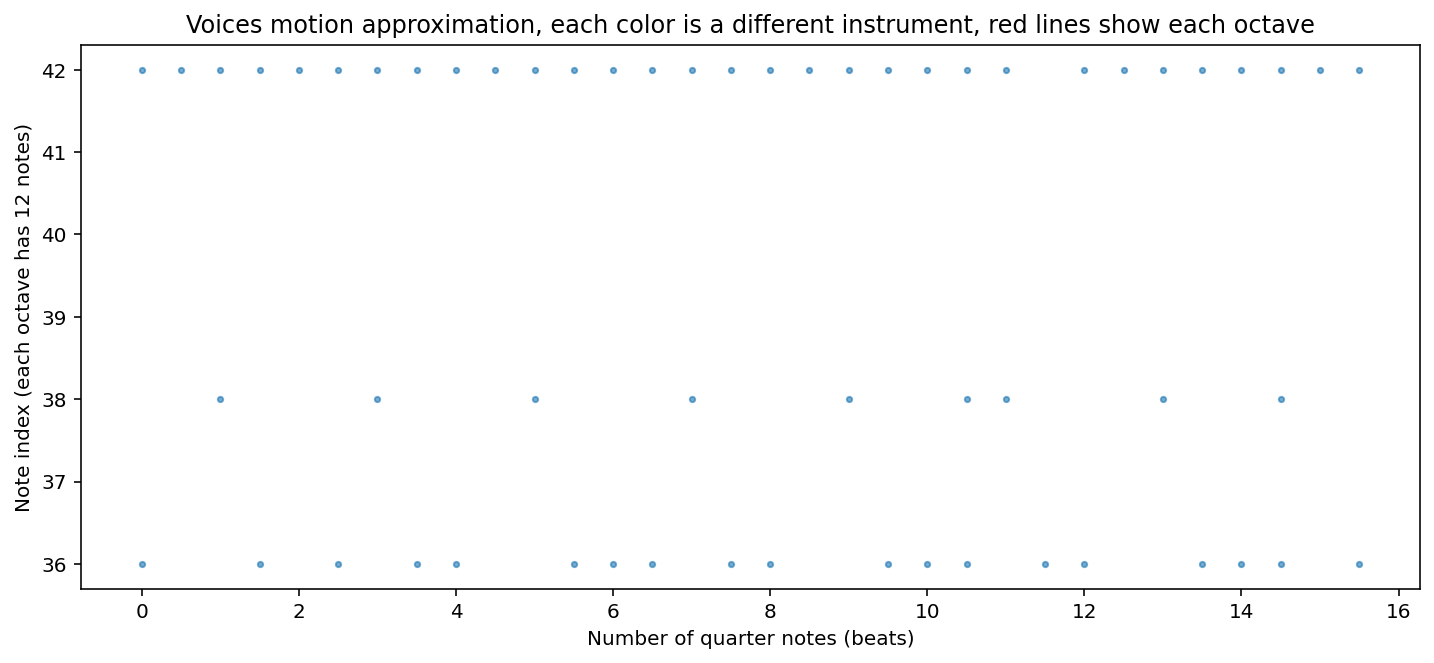

In [23]:
import matplotlib.lines as mlines

def extract_notes(midi_part):
    parent_element = []
    ret = []
    for nt in midi_part.flat.notes:        
        if isinstance(nt, note.Note):
            ret.append(max(0.0, nt.pitch.ps))
            parent_element.append(nt)
        elif isinstance(nt, chord.Chord):
            for pitch in nt.pitches:
                ret.append(max(0.0, pitch.ps))
                parent_element.append(nt)
    
    return ret, parent_element

def print_parts_countour(midi):
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(1, 1, 1)
    minPitch = pitch.Pitch('C10').ps
    maxPitch = 0
    xMax = 0
    
    # Drawing notes.
    for i in range(len(midi.parts)):
        top = midi.parts[i].flat.notes                  
        y, parent_element = extract_notes(top)
        if (len(y) < 1): continue
            
        x = [n.offset for n in parent_element]
        ax.scatter(x, y, alpha=0.6, s=7)
        
        aux = min(y)
        if (aux < minPitch): minPitch = aux
            
        aux = max(y)
        if (aux > maxPitch): maxPitch = aux
            
        aux = max(x)
        if (aux > xMax): xMax = aux
    
    for i in range(1, 10):
        linePitch = pitch.Pitch('C{0}'.format(i)).ps
        if (linePitch > minPitch and linePitch < maxPitch):
            ax.add_line(mlines.Line2D([0, xMax], [linePitch, linePitch], color='red', alpha=0.1))            

    plt.ylabel("Note index (each octave has 12 notes)")
    plt.xlabel("Number of quarter notes (beats)")
    plt.title('Voices motion approximation, each color is a different instrument, red lines show each octave')
    plt.show()

# Focusing only on 6 first measures to make it easier to understand.
print_parts_countour(base_midi.measures(0, 6))

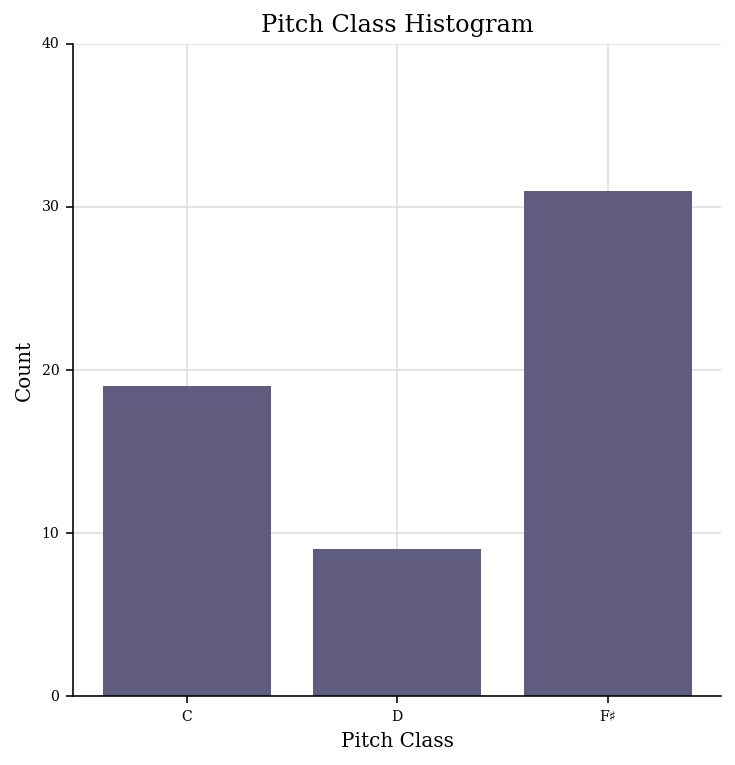

In [24]:
base_midi.plot('histogram', 'pitchClass', 'count')

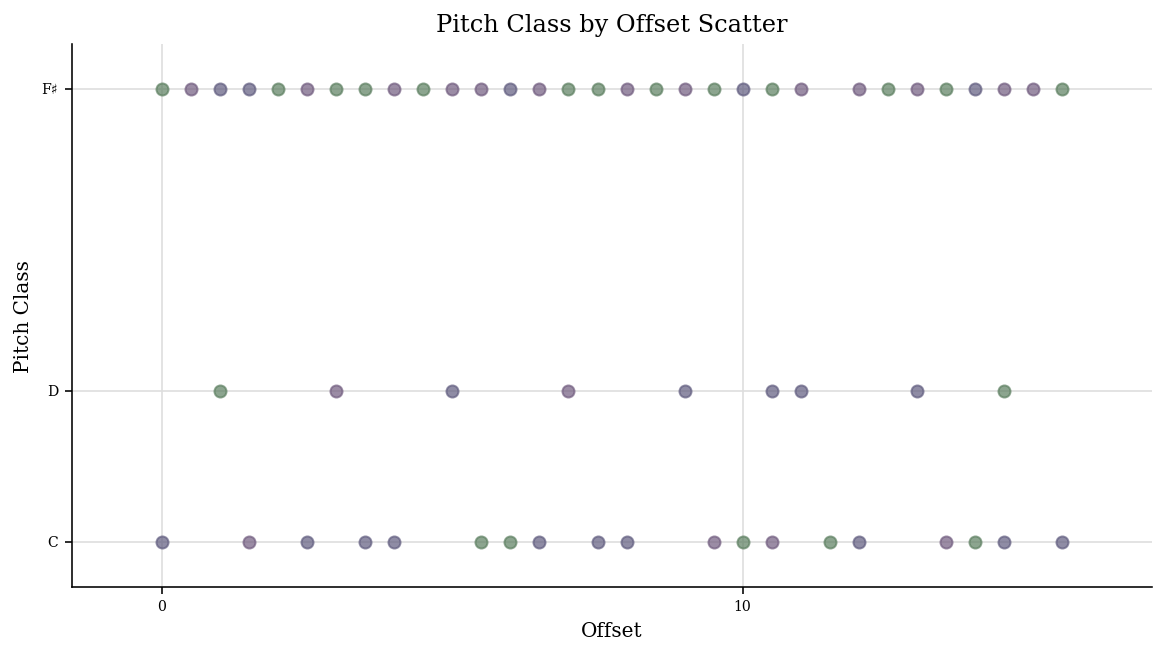

In [25]:
base_midi.plot('scatter', 'offset', 'pitchClass')